<a href="https://colab.research.google.com/github/alvumu/TGINE/blob/main/Practica1/3_2_scrapyJSON_LD_digitalTrends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scrapy rawling JSON-LD (DigitalTrends)

## Parte 1- Compilar datos de documentos web (0,75 puntos)
En el ejemplo siguiente definimos un crawler en Scrapy para extraer noticias de los metadatos de las páginas web.
DigitalTrends y otros blogs publican metadatos en formato JSON-LD (https://json-ld.org/) que permite obtener información estructurada de las webs. En este caso, tendremos que obtener esos objetos JSON-LD y extraer su información en el formato de noticia (https://schema.org/NewsArticle) publicado en Schema.org


In [1]:
!pip3 install -U scrapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.4/286.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 8.9 MB/s eta 0:00:00


In [2]:
!pip3 install stanza
import stanza
stanza.download('en')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 933.2/933.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 10.2 MB/s eta 0:00:00


INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


In [3]:
import scrapy
import sys
import json
import locale
import time
import random

import hashlib

from bs4 import BeautifulSoup


# Para cada crawler que nos definimos nos debemos crear una clase Spider que debe heredar de la clase scrapy.Spider

class DigitalTrendsSpider (scrapy.Spider):
    name = 'DigitalTrends'

    # Decimos que el dominio válido es el de la UM
    allowed_domains = ['www.digitaltrends.com']

    # podemos definir las páginas de inicio
    start_urls = ['https://www.digitaltrends.com']

    # para evitar que el sitio te bloquee por usar scrapy es interesante cambiar el USER_AGENT
    # El user agent por defecto de Scrapy cuando hace una petición es
    # Scrapy/VERSION (+https://scrapy.org)
    custom_settings = {
        'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    }

    nDocumentos = 0
    visited_urls = set()

    # debemos de implementar este método que se llamará para cada una de las páginas que se vayan analizando
    def parse (self, response):
        """
        @inherit

        @param self
        @param response
        """

        if self.nDocumentos >= 1500:
          return

        # Guardamos la URL del sitio que se está visitando
        url = str(response.request.url).strip()

        # Cogemos el contenido relevante y para eso debemos usar selectores CSS
        for article in response.css ('.b-page '):

            # Cogemos el contenido del título
            title = str (article.css ('.b-headline__title  ').get ()).strip()
            title = BeautifulSoup (title, 'html.parser').get_text().strip()

            # autor
            autor = str (article.css ('.author.url.fn ').get ()).strip()
            autor = BeautifulSoup (autor, 'html.parser').get_text().strip()

            # Date
            date = str (article.css ('.b-byline__time.date.dtreviewed').get ()).strip()
            date = BeautifulSoup (date, 'html.parser').get_text().strip()

            #Content
            content = "".join (article.css ('.b-content.b-single__content.h-article-content ').get ())
            content = BeautifulSoup (content, 'html.parser').get_text().strip().replace("\"","").replace("\n","")

            data = {
                'url' : url,
                'title': title,
                'autor': autor,
                'date': date,
                'content': content
            }


            title_hash = hashlib.md5(title.encode()).hexdigest()

            filename = f"{title_hash}.json"

            # Guardamos el documento si tiene contenido y título
            if content and title:
                print ("-------------------------")
                print (url)
                print (title)
                print (autor)
                print (date)
                print (content)
                print ("-------------------------")
                self.nDocumentos = self.nDocumentos + 1
                with open ('digitalTrends/' + filename, 'w') as f:
                    json.dump (data, f, indent = 4)



        # Obtenemos todas las otros links de la página representados por la etiqueta <a>


        url_in_current_document = response.css ('a')

        for next_page in url_in_current_document:
            # Para limitar que solamente se parseen las noticias dentro de 'https://www.digitaltrends.com/computing/ o https://www.digitaltrends.com/mobile/'
            # obtenemos el atributo href de la etiqueta <a> y parseamos la página

            url_str = str(next_page.css('::attr(href)').get())


            if ("https://www.digitaltrends.com/computing/" in url_str) or ("/mobile/" in url_str) and url_str not in self.visited_urls and self.nDocumentos < 1500:
              self.visited_urls.add(url_str)
              yield response.follow (next_page, self.parse)

In [4]:
import os
import scrapy
from scrapy.crawler import CrawlerProcess

# Creamos un proceso de Crawler podemos poner distintas settings que están definidas en la documentación.
# Entre ellas podemos ocular los logs del proceso de Crawling.
process = CrawlerProcess(settings={
    "LOG_ENABLED": False,
    # Used for pipeline 1
})

# Como se ha definido anteriormente en el RSSCrawler, los ficheros se van a almacenar en la carpeta "rss"
# Comprobamos que existe la carpeta y si no existe la creamos
if (not os.path.exists('digitalTrends')):
    os.mkdir('digitalTrends')

# Creamos el proceso con el RSSSpider
process.crawl(DigitalTrendsSpider)
# Ejecutamos el Crawler
process.start()

DEBUG:scrapy.core.engine:Crawled (200) <GET https://www.digitaltrends.com/computing/chatgpt-can-browse-the-internet-again/> (referer: https://www.digitaltrends.com/computing/how-to-use-openai-chatgpt-text-generation-chatbot/)
DEBUG:scrapy.core.engine:Crawled (200) <GET https://www.digitaltrends.com/computing/openai-fires-ceo/> (referer: https://www.digitaltrends.com/computing/how-to-use-openai-chatgpt-text-generation-chatbot/)
DEBUG:scrapy.core.engine:Crawled (200) <GET https://www.digitaltrends.com/computing/chatgpt-bing-hands-on/> (referer: https://www.digitaltrends.com/computing/how-to-use-openai-chatgpt-text-generation-chatbot/)
DEBUG:scrapy.core.engine:Crawled (200) <GET https://www.digitaltrends.com/computing/heres-why-people-are-saying-gpt-4-is-getting-lazy/> (referer: https://www.digitaltrends.com/computing/how-to-use-openai-chatgpt-text-generation-chatbot/)
DEBUG:scrapy.core.engine:Crawled (200) <GET https://www.digitaltrends.com/computing/ia-writer-7-chatgpt-dialog-partner/> 

In [5]:
def contar_archivos_en_carpeta(ruta):
    try:
        # Lista todos los archivos en la carpeta
        archivos = os.listdir(ruta)

        # Filtra solo los archivos (no directorios)
        archivos = [archivo for archivo in archivos if os.path.isfile(os.path.join(ruta, archivo))]

        # Devuelve el número de archivos
        return len(archivos)
    except Exception as e:
        print(f"Error al contar archivos: {e}")
        return None

contar_archivos_en_carpeta("digitalTrends")

1500

Parte 2 – Buscador (0,75 puntos)


In [6]:
!pip install whoosh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 4.7 MB/s eta 0:00:00


In [7]:
from whoosh.index import create_in, open_dir
from whoosh.fields import Schema, TEXT, ID, DATETIME
from whoosh.qparser import QueryParser
from datetime import datetime
from dateutil import parser
from whoosh.analysis import StemmingAnalyzer
import re


In [8]:
# Define el esquema para el índice de Whoosh
schema = Schema(
    url=ID(unique=True, analyzer = StemmingAnalyzer()),
    title=TEXT(stored=True,analyzer = StemmingAnalyzer()),
    author=TEXT(stored=True,analyzer = StemmingAnalyzer()),
    date=DATETIME(stored=True),
    content=TEXT(stored=True,analyzer = StemmingAnalyzer())
)

index_dir = "whooshIndex"
if not os.path.exists(index_dir):
    os.mkdir(index_dir)
    ix = create_in(index_dir, schema)
else:
    ix = open_dir(index_dir)



In [9]:
# Agrega los documentos al índice
# Aquí deberías leer tus archivos y agregarlos al índice
# Utiliza el bloque 'with' para garantizar que el índice se cierre correctamente
with ix.writer() as writer:
# Recorre todos los archivos en el directorio digitalTrends
  for filename in os.listdir('digitalTrends'):
      if filename.endswith(".json"):  # Asegúrate de que sean archivos JSON
          file_path = os.path.join('digitalTrends', filename)
          with open(file_path, 'r', encoding='utf-8') as file:
              try:
                  file_data = json.load(file)
                  date_string_clean = re.sub(r'\s+\d+:\d+[A|P]M', '', file_data['date'])
                  if date_string_clean != "None" :
                    date_obj = datetime.strptime(date_string_clean, '%B %d, %Y')
                  else :
                    date_obj = None
                  # Agrega los documentos al índice
                  writer.add_document(
                     url=file_data['url'],
                     title=file_data['title'],
                     author=file_data['autor'],
                     date = date_obj,
                     content=file_data['content']
                  )
              except json.JSONDecodeError as e:
                  print(f"Error al procesar el archivo {filename}: {e}")



In [10]:
from whoosh.index import open_dir
from whoosh.qparser import QueryParser,FuzzyTermPlugin
from whoosh import scoring
from whoosh.spelling import QueryCorrector
from whoosh.highlight import Highlighter, ContextFragmenter
from whoosh.qparser.dateparse import DateParserPlugin
from whoosh.analysis import StemmingAnalyzer


# Función para realizar búsquedas
def buscar_en_archivos(queryWords="", queryDate="", sortedBy="date", directory='whooshIndex'):
    # Se abre el índice existente o se crea uno nuevo si no existe
    ix = open_dir(directory)

    # Se crea un QueryParser para buscar en los campos específicos
    with ix.searcher(weighting=scoring.BM25F()) as searcher:
        #Indicamos que el parser va a ser sobre el campo content
        parser = QueryParser("content", schema=ix.schema)
        #Añadimos los plugins necesarios para las funcionalidades descritas
        #Plugin valido para realizar las busquedas por fechas
        parser.add_plugin(DateParserPlugin())
        # Añadir Stemming al parser para búsqueda más flexible
        parser.add_plugin(FuzzyTermPlugin())
        # Se inicializa la consulta combinada con la búsqueda por palabras y fecha
        user_query = parser.parse(queryWords)  # Búsqueda por palabras
        if queryDate:  # Si se proporciona una fecha, se agrega a la consulta
            date_query = parser.parse(queryDate)
            user_query = user_query & date_query

       # Se corrige la consulta en caso de que esté mal realizada
        correction = searcher.correct_query(q=user_query,qstring=queryWords)
        if correction.query != user_query:
          print("Did you mean:", correction.string)
        # Se procede a realizar la busqueda
        search_results = searcher.search(correction.query, limit=None, sortedby=sortedBy)
        # Configuramos el fragmenter para resaltar fragmentos de texto
        fragmenter = ContextFragmenter(maxchars=200, surround=30)
        highlighter = Highlighter(fragmenter=fragmenter)
        # Mostramos los resultados de las noticias que se han encontrado según las condiciones del usuario
        for hit in search_results:
            print(f"Título: {hit['title']}")
            print(f"Autor: {hit['author']}")
            print(f"Fecha: {hit['date']}")
            print(f"Fragmento de contenido: {hit.highlights('content')}")
            print("--------------")


In [11]:
# Llamar a la función para realizar las búsquedas
buscar_en_archivos(queryWords="game", queryDate="date:[2022-01-01 TO 2022-12-28]", sortedBy="author")


Título: Sony’s new InZone gaming headsets raise the bar for PS5 audio
Autor: Arif Bacchus
Fecha: 2022-06-28 00:00:00
Fragmento de contenido: Along with new <b class="match term0">gaming</b> monitors, Sony has...pressure so you can <b class="match term1">game</b> for hours. You can expect...I built a couch <b class="match term0">gaming</b> PC that puts the PS5
--------------
Título: How to use Handoff on a Mac
Autor: Arif Bacchus
Fecha: 2022-02-01 00:00:00
Fragmento de contenido: a chance to fix Mac <b class="match term0">gaming</b> for good in 2024									Save
--------------
Título: 4 ways the Nvidia RTX 3090 Ti struggles, and 1 way it’s great
Autor: Alex Blake
Fecha: 2022-03-29 00:00:00
Fragmento de contenido: GPU.”In almost every <b class="match term1">game</b> TweakTown tested, the...it makes 4K ultra <b class="match term0">gaming</b> at 120 frames per...reach. Even 8K <b class="match term0">gaming</b> at 60 fps, as silly
--------------
Título: I tried Stage Manager on my Mac, and 

Parte 3 – Vectorización (0,5 puntos)

In [12]:
import os
import json

# Ruta al directorio 'digitalTrends'
directory_path = 'digitalTrends'

# Lista para almacenar el contenido de 'content' de cada archivo
content_list = []

# Recorre todos los archivos en el directorio 'digitalTrends'
for filename in os.listdir(directory_path):
    if filename.endswith(".json"):  # Verifica si es un archivo JSON
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            try:
                file_data = json.load(file)
                # Obtén el campo 'content' de cada archivo y añádelo a la lista
                content = file_data.get('content', '')  # Si 'content' no existe, asigna una cadena vacía
                content_list.append(content)
            except json.JSONDecodeError as e:
                print(f"Error al procesar el archivo {filename}: {e}")

# Ahora content_list contiene el campo 'content' de cada archivo en 'digitalTrends'
# Puedes utilizar content_list para convertir el texto a vectores usando TfidfVectorizer o cualquier otro método



In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# Crear un objeto TfidfVectorizer con opciones de preprocesamiento
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',  # Usar stopwords del inglés
    min_df=10  # Filtrar términos que aparecen en menos de 10 documentos
)


# Obtener la matriz documento-término
matriz_tfidf = tfidf_vectorizer.fit_transform(content_list)

# Obtener los términos más relevantes de toda la colección (los 10 términos con mayor TF-IDF)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = matriz_tfidf.max(axis=0).toarray().flatten()
indices_top_10 = tfidf_scores.argsort()[-10:][::-1]
top_10_terminos = [feature_names[i] for i in indices_top_10]

feature_names_count = tfidf_vectorizer.get_feature_names_out()
term_frequencies = matriz_tfidf.sum(axis=0).A1
indices_top_100 = term_frequencies.argsort()[-100:][::-1]
top_100_repetidos = [feature_names_count[i] for i in indices_top_100]

print(matriz_tfidf)
# Mostrar resultados
print("Los 10 términos más relevantes de toda la colección (con mayor TF-IDF):")
print(top_10_terminos)
print("\nLos 100 términos más repetidos en la colección:")
print(top_100_repetidos)


  (0, 1339)	0.015874422091032642
  (0, 3187)	0.01203342976532926
  (0, 5767)	0.018165117574360363
  (0, 5007)	0.032393048596036256
  (0, 2565)	0.031414171153971944
  (0, 113)	0.018234349352829776
  (0, 4617)	0.029790657862880578
  (0, 2630)	0.014496093266784004
  (0, 2764)	0.02663598971827502
  (0, 2404)	0.013934436789248413
  (0, 4501)	0.03156810902591775
  (0, 5056)	0.012518698952269244
  (0, 3622)	0.01837490038162782
  (0, 4434)	0.011779739976132214
  (0, 67)	0.01474526982644724
  (0, 5940)	0.026870779006948575
  (0, 5527)	0.022383687079595965
  (0, 115)	0.025501574163243966
  (0, 2361)	0.011816748734511235
  (0, 1794)	0.02419196157843725
  (0, 4672)	0.007107306264820695
  (0, 2048)	0.007112043425114211
  (0, 1711)	0.025633726974929473
  (0, 4905)	0.011437579568643119
  (0, 3767)	0.01990237047913896
  :	:
  (1499, 693)	0.020724631781654474
  (1499, 2405)	0.020166901736948167
  (1499, 4211)	0.015775608520632842
  (1499, 4731)	0.005307999636533682
  (1499, 6339)	0.00833903957969978
  

PARTE 4: Detección de entidades

In [20]:
nDocumentos = 0

for filename in os.listdir('digitalTrends'):
    if nDocumentos >= 10:
        break

    if filename.endswith(".json"):  # Asegúrate de que sean archivos JSON
        file_path = os.path.join('digitalTrends', filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            try:
                file_data = json.load(file)
                date_string_clean = re.sub(r'\s+\d+:\d+[A|P]M', '', file_data['date'])
                if date_string_clean != "None":
                    date_obj = datetime.strptime(date_string_clean, '%B %d, %Y')
                else:
                    date_obj = None

                # Agrega los documentos al índice
                dictEntities = {t: [] for t in ["LOC", "MISC", "FAC", "ORG", "NORP", "GPE", "PERSON", "PRODUCT", "EVENT", "WORK_OF_ART", "LAW", "LANGUAGE", "TIME", "PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL", "DATE"]}
                pipelineStanza = stanza.Pipeline(lang='en', processors='tokenize, mwt, pos, lemma, depparse, ner')
                entityTypes = pipelineStanza(file_data['content'])

                for sentence in entityTypes.sentences:
                    for ent in sentence.ents:
                        if ent.text not in dictEntities[ent.type]:
                            dictEntities[ent.type].append(ent.text)

                data = {
                    'url': file_data['url'],
                    'title': file_data['title'],
                    'autor': file_data['autor'],
                    'date': file_data['date'],
                    'content': file_data['content'],
                    'location': dictEntities["LOC"],
                    'miscelaneous': dictEntities['MISC'],
                    'norp': dictEntities['NORP'],
                    'facility': dictEntities['FAC'],
                    'organization': dictEntities['ORG'],
                    'countries': dictEntities['GPE'],
                    'person': dictEntities['PERSON'],
                    'product': dictEntities['PRODUCT'],
                    'event': dictEntities['EVENT'],
                    'workOfArt': dictEntities['WORK_OF_ART'],
                    'law': dictEntities['LAW'],
                    'language': dictEntities['LANGUAGE'],
                    'time': dictEntities['TIME'],
                    'percent': dictEntities['PERCENT'],
                    'money': dictEntities['MONEY'],
                    'quantity': dictEntities['QUANTITY'],
                    'ordinal': dictEntities['ORDINAL'],
                    'cardinal': dictEntities['CARDINAL'],
                    'entityDate': dictEntities['DATE']
                }

                title_hash = hashlib.md5(file_data['title'].encode()).hexdigest()
                filename = f"Entity{title_hash}.json"

                # Guardamos el documento si tiene contenido y título
                if file_data['content'] and file_data['title']:
                    print("-------------------------")
                    print(file_data['url'])
                    print(file_data['title'])
                    print(file_data['autor'])
                    print(file_data['date'])
                    print(file_data['content'])
                    for k, v in dictEntities.items():
                        print(k + "->" + str(v))
                    print("-------------------------")
                    nDocumentos = nDocumentos + 1
                    if not os.path.exists("digitalTrendsEntities/"):
                        os.mkdir("digitalTrendsEntities/")

                    with open('digitalTrendsEntities/' + filename, 'w') as f:
                        json.dump(data, f, indent=4)

            except json.JSONDecodeError as e:
                print(f"Error al procesar el archivo {filename}: {e}")



INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /stanfordnlp/stanza-resources/main/resources_1.7.0.json HTTP/1.1" 200 46131


INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | combined_nocharlm         |
| depparse  | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /stanfo

-------------------------
https://www.digitaltrends.com/mobile/how-to-sell-your-iphone/
How to sell your iPhone (without getting ripped off)
Simon Hill
April 6, 2021
If you’re shopping for the latest iPhone or want to escape Apple altogether and go Android, selling your current iPhone can generate cash to put toward the new device. Thankfully, iPhones tend to retain their resale value fairly well compared to leading Android brands, so selling your old one when the time comes is always a solid plan.ContentsCompletely wipe your iPhoneSell it to others directly on Craigslist, eBay, etc.Trade it in for creditSell it to a companyHow much is your old iPhone worth?Final tip: Sell soonShow 1 more itemHowever, there are a few things you should do to protect yourself from scams. Here’s our guide to selling your iPhone to get the best return possible.DecluttrIf you have a newer model like the iPhone 13 and want to upgrade, then you could lose a chunk of change by dragging your feet. That’s becaus

INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | combined_nocharlm         |
| depparse  | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /stanfo

-------------------------
https://www.digitaltrends.com/computing/dell-xps-15-vs-xps-17/
Dell XPS 15 vs. XPS 17: high-performance siblings duke it out
Luke Larsen
June 29, 2023
You’d be forgiven for mistaking the Dell XPS 17 for only a slightly bigger XPS 15. Both have large displays packed into the smallest chassis possible, and both boast some ambitious performance claims. However, there’s more going on between the two than meets the eye.ContentsSpecsDesignPortsDisplayPerformanceBattery lifeConclusionShow 2 more itemsJust how big of a difference is there between the XPS 15 9530 and the XPS 17 9730? Here’s everything you need to know about these two great laptops, and which you should buy. Note that both laptops received refreshes in 2023 that upped the CPU and GPU but left the rest of the laptop alone. Neither is as compelling compared to the competition as it was in previous generations.			Recommended Videos		Specs Dell XPS 15 9530Dell XPS 17 9730Dimensions13.56 inches x 9.06 inches

INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | combined_nocharlm         |
| depparse  | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443


-------------------------
https://www.digitaltrends.com/mobile/how-to-use-waze/
How to use Waze: A simple guide
Jackie Dove
March 26, 2021
Waze is a free, ad-supported interactive navigation app owned by Google and available for both iOS and Android. It uses your smartphone’s GPS service to calculate routes between destinations and gathers information via social media-based crowdsourcing to alert you to road conditions while you drive. Drivers on the Waze platform act as the road’s eyes and ears to alert other drivers about traffic, police, accidents, detours, speed traps, construction, and anything happening nearby or on your route.ContentsGet startedPlot your routeSee only the info you needGet real-time infoReport incidentsIntegrationsProtect your privacyBottom LineShow 3 more itemsThe more people contribute to Waze, the more accurate it becomes as events get verified and updated. The app automatically alters your route to avoid traffic jams. It not only helps you avoid congestion in

DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /stanfordnlp/stanza-resources/main/resources_1.7.0.json HTTP/1.1" 200 46131


INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | combined_nocharlm         |
| depparse  | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /stanfo

-------------------------
https://www.digitaltrends.com/computing/how-to-increase-your-internet-speed/
How to increase your internet speed
Tyler Lacoma
September 20, 2023
There is nothing more frustrating than your internet moving along at a snail’s pace. Web pages take forever to load, and games and streaming services experience lag. With Zoom meetings becoming a more regular occurrence, any significant slowdown in your internet makes working at home much more difficult, too.ContentsReset your routerManage your Wi-Fi channelsManage the devices on your networkUsing Ethernet connections'Flush' your DNSSwitch to a faster browserAdd an extension to manage your cacheConsider using a VPNIf necessary, upgrade your Wi-Fi system or bandwidthShow 4 more items			Recommended Videos							Difficulty									Moderate									Duration									30 minutes									What You Need				RouterEthernetDNSWi-FiFortunately, you don’t have to suffer through a slow internet speed anymore, especially with so many 

INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | combined_nocharlm         |
| depparse  | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443


-------------------------
https://www.digitaltrends.com/computing/google-nest-wifi-wifi-6-missed-opportunity/
Google’s new Nest router doesn’t use Wi-Fi 6. Here’s why that’s shortsighted
Chuong Nguyen
October 17, 2019
At its Made by Google event, Google unveiled its Nest Wifi access points alongside the flagship Pixel 4 smartphones and its least expensive Pixelbook to date. The Nest Wifi has some pleasing aesthetics — it looks as if it was formed from clay to resemble stoneware jars. The built-in Google Assistant is an attractive, forward-thinking feature as well.ContentsYears of missed upgrade opportunitiesWhat you miss without Wi-Fi 6However, for tomorrow and into the future, the glaring absence of Wi-Fi 6 support makes the Nest Wifi less future-proof than a router should be.			Recommended Videos		Google defended its decision to leave out Wi-Fi 6, citing cost and the lack of available compatible devices in your home. But this any more than just a cop-out?		Related						This dongle ca

DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /stanfordnlp/stanza-resources/main/resources_1.7.0.json HTTP/1.1" 200 46131


INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | combined_nocharlm         |
| depparse  | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /stanfo

-------------------------
https://www.digitaltrends.com/computing/mechanical-keyboard-switches-explained/
Mechanical keyboard switches: Here’s everything you need to know
Jon Martindale
March 30, 2021
There’s one big question when buying your first mechanical keyboard: What switch should you use? Between more than half a dozen brands, each with different switch models, it can be tough to know what switch is right for you. Worse, each switch has a different feel, catering to different uses and preferences.ContentsImportant termsCherry MX — Red, Black, Brown, Blue, SpeedLogitech — Romer G, GX BlueRazer — Green, Orange, Yellow, Opto-MechanicalSteelseries — QX2 and OmniPointRoccatKaihua/Kailh — Red, Black, Brown, BlueGateron — Red, Black, Brown, Blue, ClearShow 3 more itemsWe’ve rounded up all of the mechanical keyboard switches from leading peripheral brands to help you sort through the options. There are many differences between various keyboard switches, but the one you should use mostl

INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | combined_nocharlm         |
| depparse  | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /stanfo

-------------------------
https://www.digitaltrends.com/computing/6-biggest-mistakes-in-recent-star-wars-movies-tv-shows-we-can-all-agree-on/
The 6 biggest mistakes in recent Star Wars movies and TV shows we can all agree on
Luke Larsen
July 7, 2023
There’s no question that the past eigh years of Star Wars have been divisive. No one’s going to debate that. Some fans hate the Sequel Trilogy but love The Mandalorian and Rogue One. Some adore The Last Jedi but hate Rise of Skywalker. And then there are plenty that only like Andor. And then there are people like me, who find plenty to enjoy in all of the above.Contents6. The shoddy production values of Obi-Wan Kenobi5. The logo moment4. The way The Book of Boba Fett was structured3. The botched marketing and release of Solo2. Not providing more explanation for the return of Palpatine1. Not finding a way to get Luke, Leia, and Han back togetherShow 1 more itemThere are some decisions, though, that we can all agree didn’t play out how Lucasf

INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | combined_nocharlm         |
| depparse  | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443


-------------------------
https://www.digitaltrends.com/mobile/google-targets-apple-for-bullying-imessage-lock-ecosystem/
Google blasts Apple over bullying, peer pressure tactics keeping users on iMessage
Nadeem Sarwar
January 10, 2022
When an Android phone user texts an iPhone person, it appears in a green bubble in iMessage. It’s Apple’s way of telling that the sender is not an iPhone user. But that green bubble is not particularly forgiving from a social standpoint; plus, it just led to some heated commentary from Google, which alleged that Apple engaged in bullying tactics.ContentsHow iMessage stands out in the message-verse?The green bubble divide is not newWhat does Google want?The Wall Street Journal recently highlighted how the “green bubble effect” is being weaponized for creating social pressure. Teens feel ostracized for using an Android phone, because it identifies their messages with the color green. Plus, iPhones don’t come cheap and are often seen as a social status symb

DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /stanfordnlp/stanza-resources/main/resources_1.7.0.json HTTP/1.1" 200 46131


INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | combined_nocharlm         |
| depparse  | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /stanfo

-------------------------
https://www.digitaltrends.com/mobile/best-samsung-galaxy-watch-6-bands/
The best Samsung Galaxy Watch 6 bands: 15 best ones in 2023
Christine Romero-Chan
August 20, 2023
Samsung has launched the next iteration of its smartwatches, the Galaxy Watch 6 and Galaxy Watch 6 Classic. The latest and greatest Galaxy Watches ship with Wear OS 4 and have the best new features, including app folders and custom colors in One UI Watch 5.With the Galaxy Watch 6 series, you also have advanced sleep coaching for better sleep tracking and Food and Drug Administration-certified heart rhythm notification tracking, as well as ECG measurements for irregular heart rhythms.Though Samsung has its own official watch bands for the Galaxy Watch 6 and Watch 6 Classic, you can take the personalization even further since both watches support all standard 20mm watch bands too. As such, here are the best watch bands you can buy for the Galaxy Watch 6 and Galaxy Watch 6 Classic.				Galaxy Watc

INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | combined_nocharlm         |
| depparse  | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


-------------------------
https://www.digitaltrends.com/computing/razer-blade-stealth-13-review/
Razer Blade Stealth 13 (Late 2019) hands-on review: For real
Arif Bacchus
November 14, 2019
Razer Blade Stealth 13 (Late 2019) hands-on review: For real			 MSRP $1,800.00					“With options for a powerful GTX 1650 card in its small chassis, Razer has finally made the Blade Stealth a real gaming laptop.”								Pros									Fantastic graphics options											Debuts Intel’s Ice Lake processors											Rigid build quality											Same beautiful design									Cons									Can get warm during gaming											Fingerprint magnet					Razer is a gaming brand first and foremost, which has always made its 13-inch Blade Stealth a bit of an odd duck. Without a powerful GPU, it could never be sold as a true gaming laptop.ContentsMeet “Mercury White”Ice Lake and Iris Plus will send chills down your spineA GTX video card in a 13-inch laptop? YupWorth the upgradeThis time around, that’s changing. Raz

In [21]:
# Define el esquema para el índice de Whoosh
from whoosh.fields import KEYWORD
schema = Schema(
    url=ID(unique=True, analyzer = StemmingAnalyzer()),
    title=TEXT(stored=True,analyzer = StemmingAnalyzer()),
    author=TEXT(stored=True,analyzer = StemmingAnalyzer()),
    date=DATETIME(stored=True),
    content=TEXT(stored=True,analyzer = StemmingAnalyzer()),
    miscelaneous=KEYWORD(stored=True, commas=True),
    location = KEYWORD(stored=True, commas = True),
    norp = KEYWORD(stored=True,commas = True),
    facility = KEYWORD(stored=True,commas = True),
    organization = KEYWORD(stored=True,commas = True),
    countries = KEYWORD(stored=True,commas = True),
    person = KEYWORD(stored=True,commas = True),
    product = KEYWORD(stored=True,commas = True),
    event = KEYWORD(stored=True,commas = True),
    workOfArt= KEYWORD(stored=True,commas = True),
    law = KEYWORD(stored=True,commas = True),
    language = KEYWORD(stored=True,commas = True),
    time = KEYWORD(stored=True,commas = True),
    percent = KEYWORD(stored=True,commas = True),
    money = KEYWORD(stored=True,commas = True),
    quantity = KEYWORD(stored=True,commas = True),
    ordinal = KEYWORD(stored=True,commas = True),
    cardinal = KEYWORD(stored=True,commas = True),
    entityDate = KEYWORD(stored=True,commas = True),
)

index_dir = "whooshIndexEntities"
if not os.path.exists(index_dir):
    os.mkdir(index_dir)
    ix = create_in(index_dir, schema)
else:
    ix = open_dir(index_dir)

In [22]:
# Agrega los documentos al índice
# Aquí deberías leer tus archivos y agregarlos al índice
# Utiliza el bloque 'with' para garantizar que el índice se cierre correctamente
with ix.writer() as writer:
# Recorre todos los archivos en el directorio digitalTrends
  for filename in os.listdir('digitalTrendsEntities'):
      if filename.endswith(".json"):  # Asegúrate de que sean archivos JSON
          file_path = os.path.join('digitalTrendsEntities', filename)
          with open(file_path, 'r', encoding='utf-8') as file:
              try:
                  file_data = json.load(file)
                  date_string_clean = re.sub(r'\s+\d+:\d+[A|P]M', '', file_data['date'])
                  if date_string_clean != "None" :
                    date_obj = datetime.strptime(date_string_clean, '%B %d, %Y')
                  else :
                    date_obj = None
                  # Agrega los documentos al índice
                  writer.add_document(
                     url=file_data['url'],
                     title=file_data['title'],
                     author=file_data['autor'],
                     date = date_obj,
                     content=file_data['content'],
                     location = file_data['location'],
                     norp = file_data['norp'],
                     facility = file_data['facility'],
                     organization = file_data['organization'],
                     countries = file_data['countries'],
                     person = file_data['person'],
                     product = file_data['product'],
                     event = file_data['event'],
                     workOfArt= file_data['workOfArt'],
                     law = file_data['law'],
                     language = file_data['language'],
                     time = file_data['time'],
                     percent = file_data['percent'],
                     money = file_data['money'],
                     quantity = file_data['quantity'],
                     ordinal = file_data['ordinal'],
                     cardinal = file_data['cardinal'],
                     entityDate = file_data['entityDate']
                  )

              except json.JSONDecodeError as e:
                  print(f"Error al procesar el archivo {filename}: {e}")




In [23]:
from whoosh.index import open_dir
from whoosh.qparser import QueryParser,FuzzyTermPlugin
from whoosh import scoring
from whoosh.spelling import QueryCorrector
from whoosh.highlight import Highlighter, ContextFragmenter
from whoosh.qparser.dateparse import DateParserPlugin
from whoosh.analysis import StemmingAnalyzer


# Función para realizar búsquedas
def buscar_en_archivos_entidades(queryWords="", queryDate="", fileSearch="content", sortedBy="date", directory='whooshIndexEntities'):
    # Se abre el índice existente o se crea uno nuevo si no existe
    ix = open_dir(directory)

    # Se crea un QueryParser para buscar en los campos específicos
    with ix.searcher() as searcher:
        #Indicamos que el parser va a ser sobre los campos de los tipos de entidades
        parser = QueryParser(fileSearch, schema=ix.schema)
        #Añadimos los plugins necesarios para las funcionalidades descritas
        #Plugin valido para realizar las busquedas por fechas
        parser.add_plugin(DateParserPlugin())

        # Añadir Stemming al parser para búsqueda más flexible
        user_query = parser.parse(queryWords)  # Búsqueda por palabras
        if queryDate != "":  # Si se proporciona una fecha, se agrega a la consulta
            date_query = parser.parse(queryDate)
            user_query = user_query & date_query
        search_results = searcher.search(user_query,limit=None, sortedby=sortedBy)
        print(search_results)
        # Configuramos el fragmenter para resaltar fragmentos de texto
        fragmenter = ContextFragmenter(maxchars=200, surround=30)
        highlighter = Highlighter(fragmenter=fragmenter)
        # Mostramos los resultados de las noticias que se han encontrado según las condiciones del usuario
        for hit in search_results:
            print(f"Título: {hit['title']}")
            print(f"Autor: {hit['author']}")
            print(f"Fecha: {hit['date']}")
            print(fileSearch+":",hit[fileSearch])
            print("--------------")


In [28]:
# Llamar a la función para realizar las búsquedas
buscar_en_archivos_entidades(queryWords = "Apple", fileSearch = "organization")

<Top 3 Results for Term('organization', 'Apple') runtime=0.0003150280003865191>
Título: Google’s new Nest router doesn’t use Wi-Fi 6. Here’s why that’s shortsighted
Autor: Chuong Nguyen
Fecha: 2019-10-17 00:00:00
organization: ['Google', 'Google Assistant', 'Linksys', 'Wi-Fi', 'Intel’s 10th-gen', 'Nest', 'Intel', 'Project Athena', 'Wi-Fi 6', 'Nest Wifi', 'Apple']
--------------
Título: How to sell your iPhone (without getting ripped off)
Autor: Simon Hill
Fecha: 2021-04-06 00:00:00
organization: ['Apple', 'Android', 'Craigslist', 'eBay', 'Swappa', 'Amazon', 'Walmart', 'GameStop', 'Verizon', 'Best Buy', 'PayPal', 'Average Finder', 'AT&T']
--------------
Título: Google blasts Apple over bullying, peer pressure tactics keeping users on iMessage
Autor: Nadeem Sarwar
Fecha: 2022-01-10 00:00:00
organization: ['Google', 'Apple', 'The Wall Street Journal', 'Google’s', 'Android', 'Apple’s', 'RCS', 'Reddit', '9to5Google', 'New York Times', 'Wi-Fi', 'Wall Street Journal’s', 'Fast Company', 'CNET'

In [29]:
import sys
!{sys.executable} -m spacy download en

2023-12-10 11:15:23.060385: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 11:15:23.060459: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 11:15:23.060510: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 11:15:25.015645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 64.2 MB/s eta 0:00:00
✔ Download and installation succe

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [36]:
import os
import json
import pandas as pd
import gensim
import re

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

directory_path = 'digitalTrends'  # Reemplaza con la ruta de tu carpeta

data = []  # Lista para almacenar los datos de cada archivo

# Recorre todos los archivos en el directorio 'directory_path'
for filename in os.listdir(directory_path):
    if filename.endswith(".json"):  # Verifica si es un archivo JSON
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            try:
                file_data = json.load(file)
                content = file_data.get('content', '')  # Obtiene el campo 'content' o cadena vacía si no existe
                data.append({'Filename': filename, 'Content': content})  # Agrega el nombre y contenido a la lista
            except json.JSONDecodeError as e:
                print(f"Error al procesar el archivo {filename}: {e}")

# Crea un DataFrame de pandas con los datos recolectados
df = pd.DataFrame(data)
# Muestra el DataFrame
print(df)

# Ahora se puede acceder a la columna 'Content' del DataFrame
data = df['Content'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])


                                   Filename  \
0     c8fc8accf93666aceb71465a3834c2fb.json   
1     1288728495f83c6383cf92586d2d9a48.json   
2     607f4dbb4486ff415904d53a02abac3a.json   
3     29460a404bcc2e580b6b9f6333dbefb1.json   
4     8e96d41927fd0465c313eb9add9293eb.json   
...                                     ...   
1495  2281cc08f4eeebf0193608ce1065da9c.json   
1496  15bb498205141805346da1ed068ce91a.json   
1497  25f661034d8c64ba4e709e888de32a24.json   
1498  10e58027409582886e3e62503ab09d54.json   
1499  0583289ee8a6486c26b7f1b282a3a101.json   

                                                Content  
0     If you’re shopping for the latest iPhone or wa...  
1     You’d be forgiven for mistaking the Dell XPS 1...  
2     Waze is a free, ad-supported interactive navig...  
3     There is nothing more frustrating than your in...  
4     At its Made by Google event, Google unveiled i...  
...                                                 ...  
1495  Microsoft has failed on

In [ ]:
!python3 -m spacy download en_core_web_sm

In [41]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:gensim.models.phrases:collected 502584 token types (unigram + bigrams) from a corpus of 1667943 words and 1500 sentences
INFO:gensim.models.phrases:merged Phrases<502584 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
DEBUG:gensim.utils:starting a new internal lifecycle event log for Phrases
INFO:gensim.utils:Phrases lifecycle event {'msg': 'built Phrases<502584 vocab, min_count=5, threshold=100, max_vocab_size=40000000> in 5.19s', 'datetime': '2023-12-10T11:23:20.119436', 'gensim': '4.3.2', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]', 'platform': 'Linux-5.15.120+-x86_64-with-glibc2.35', 'event': 'created'}
INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:gensim.models.phrases:collected 517034

In [42]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

Streaming output truncated to the last 5000 lines.
INFO:gensim.models.ldamodel:merging changes from 10 documents into a model of 1500 documents
INFO:gensim.models.ldamodel:topic #0 (0.250): 0.014*"new" + 0.009*"device" + 0.008*"user" + 0.007*"feature" + 0.006*"company" + 0.006*"router" + 0.006*"app" + 0.006*"window" + 0.005*"launch" + 0.005*"time"
INFO:gensim.models.ldamodel:topic #1 (0.250): 0.115*"apple" + 0.066*"iphone" + 0.048*"pro" + 0.042*"watch" + 0.035*"case" + 0.017*"headset" + 0.017*"imac" + 0.010*"fitbit" + 0.008*"new" + 0.008*"model"
INFO:gensim.models.ldamodel:topic #2 (0.250): 0.019*"laptop" + 0.011*"display" + 0.011*"gaming" + 0.011*"well" + 0.011*"performance" + 0.010*"game" + 0.010*"inch" + 0.008*"price" + 0.007*"core" + 0.007*"look"
INFO:gensim.models.ldamodel:topic #3 (0.250): 0.031*"phone" + 0.016*"camera" + 0.016*"android" + 0.014*"screen" + 0.012*"galaxy" + 0.012*"app" + 0.011*"fold" + 0.010*"feature" + 0.009*"photo" + 0.009*"look"
INFO:gensim.models.ldamodel:topi

[(0, '0.013*"new" + 0.009*"app" + 0.009*"update" + 0.008*"device" + 0.008*"user" + 0.007*"company" + 0.006*"feature" + 0.006*"window" + 0.005*"datum" + 0.005*"people"'), (1, '0.139*"apple" + 0.067*"watch" + 0.060*"iphone" + 0.036*"pro" + 0.021*"case" + 0.013*"series" + 0.010*"new" + 0.010*"face" + 0.010*"model" + 0.009*"ipad"'), (2, '0.017*"laptop" + 0.010*"inch" + 0.010*"gaming" + 0.009*"well" + 0.009*"game" + 0.009*"performance" + 0.008*"new" + 0.008*"display" + 0.008*"core" + 0.007*"price"'), (3, '0.032*"phone" + 0.017*"screen" + 0.014*"camera" + 0.013*"app" + 0.011*"android" + 0.011*"galaxy" + 0.010*"fold" + 0.010*"iphone" + 0.009*"look" + 0.008*"photo"')]


In [43]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

<ipython-input-43-bb79a6020bb1>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-43-bb79a6020bb1>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-43-bb79a6020bb1>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-43-bb79a6020bb1>:15: FutureWarning: The frame.append method is deprecated and will be removed from p

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.5610,"new, app, update, device, user, company, featu...","[shop, late, iphone, escape, apple, altogether..."
1,1,2,0.9739,"laptop, inch, gaming, well, game, performance,...","[forgive, mistake, slightly, big, large, displ..."
2,2,0,0.5949,"new, app, update, device, user, company, featu...","[free, ad, support, interactive, navigation, a..."
3,3,0,0.7838,"new, app, update, device, user, company, featu...","[frustrating, internet, move, snail, pace, web..."
4,4,0,0.6876,"new, app, update, device, user, company, featu...","[event, unveil, access, point, smartphone, lea..."
5,5,2,0.7014,"laptop, inch, gaming, well, game, performance,...","[big, question, buy, first, switch, half, doze..."
6,6,0,0.4581,"new, app, update, device, user, company, featu...","[question, eigh, year, star_war, divisive, deb..."
7,7,0,0.5118,"new, app, update, device, user, company, featu...","[android, phone, user, text, iphone, person, a..."
8,8,1,0.5349,"apple, watch, iphone, pro, case, series, new, ...","[launch, next, iteration, smartwatche, galaxy,..."
9,9,2,0.8684,"laptop, inch, gaming, well, game, performance,...","[late, hand, review, real, msrp, option, power..."


In [44]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9963,"new, app, update, device, user, company, feature, window, datum, people","[week, mark, sixth, anniversary, ransom, project, initiative, aim, help, ransomware, victim, ope..."
1,1,0.5518,"apple, watch, iphone, pro, case, series, new, face, model, ipad","[wait, iphone, upgrade, time, pounce, new, addition, legendary, confirm, event, bell, ball, year..."
2,2,0.9987,"laptop, inch, gaming, well, game, performance, new, display, core, price","[gaming, laptop, base, inch, display, large, part, fit, high_end, component, room, move, air, ar..."
3,3,0.9484,"phone, screen, camera, app, android, galaxy, fold, iphone, look, photo","[galaxy, fold, left, galaxy, fold, andy_boxall, drastically, change, camera, setup, galaxy, fold..."


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/pyth

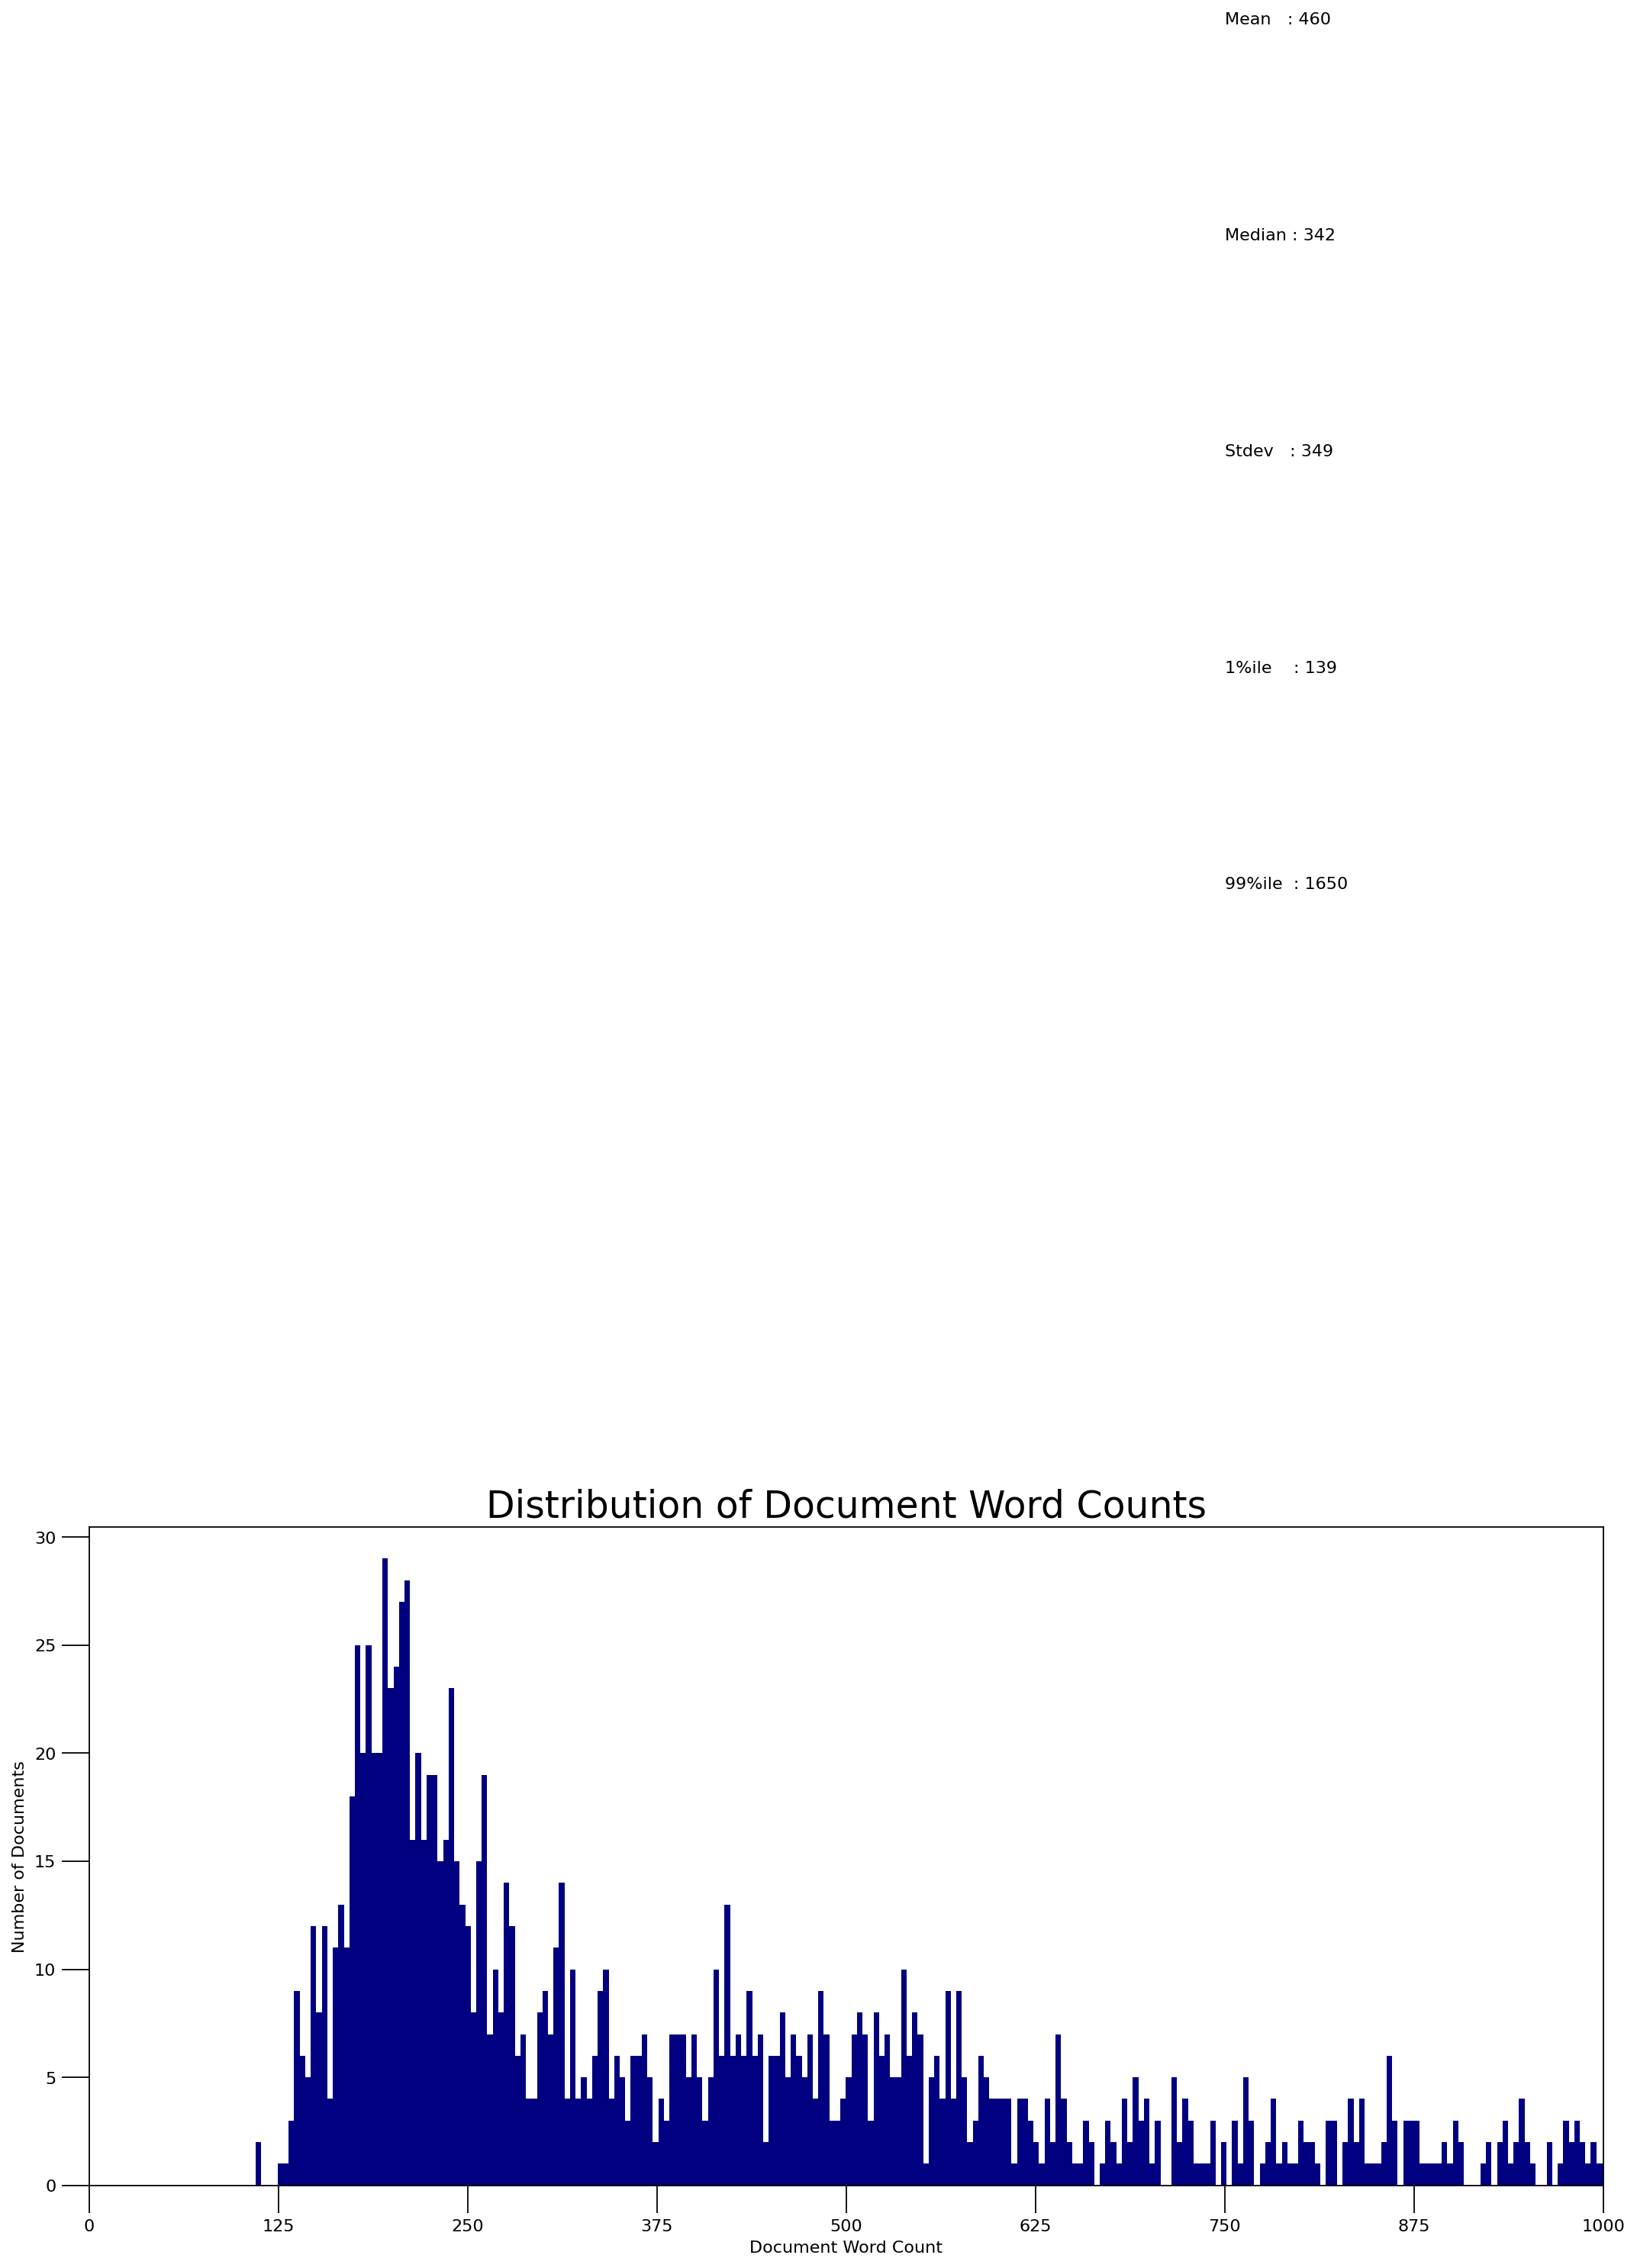

In [45]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

<ipython-input-46-cfc41bd4707a>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-46-cfc41bd4707a>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-46-cfc41bd4707a>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-46-cfc41bd4707a>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, col

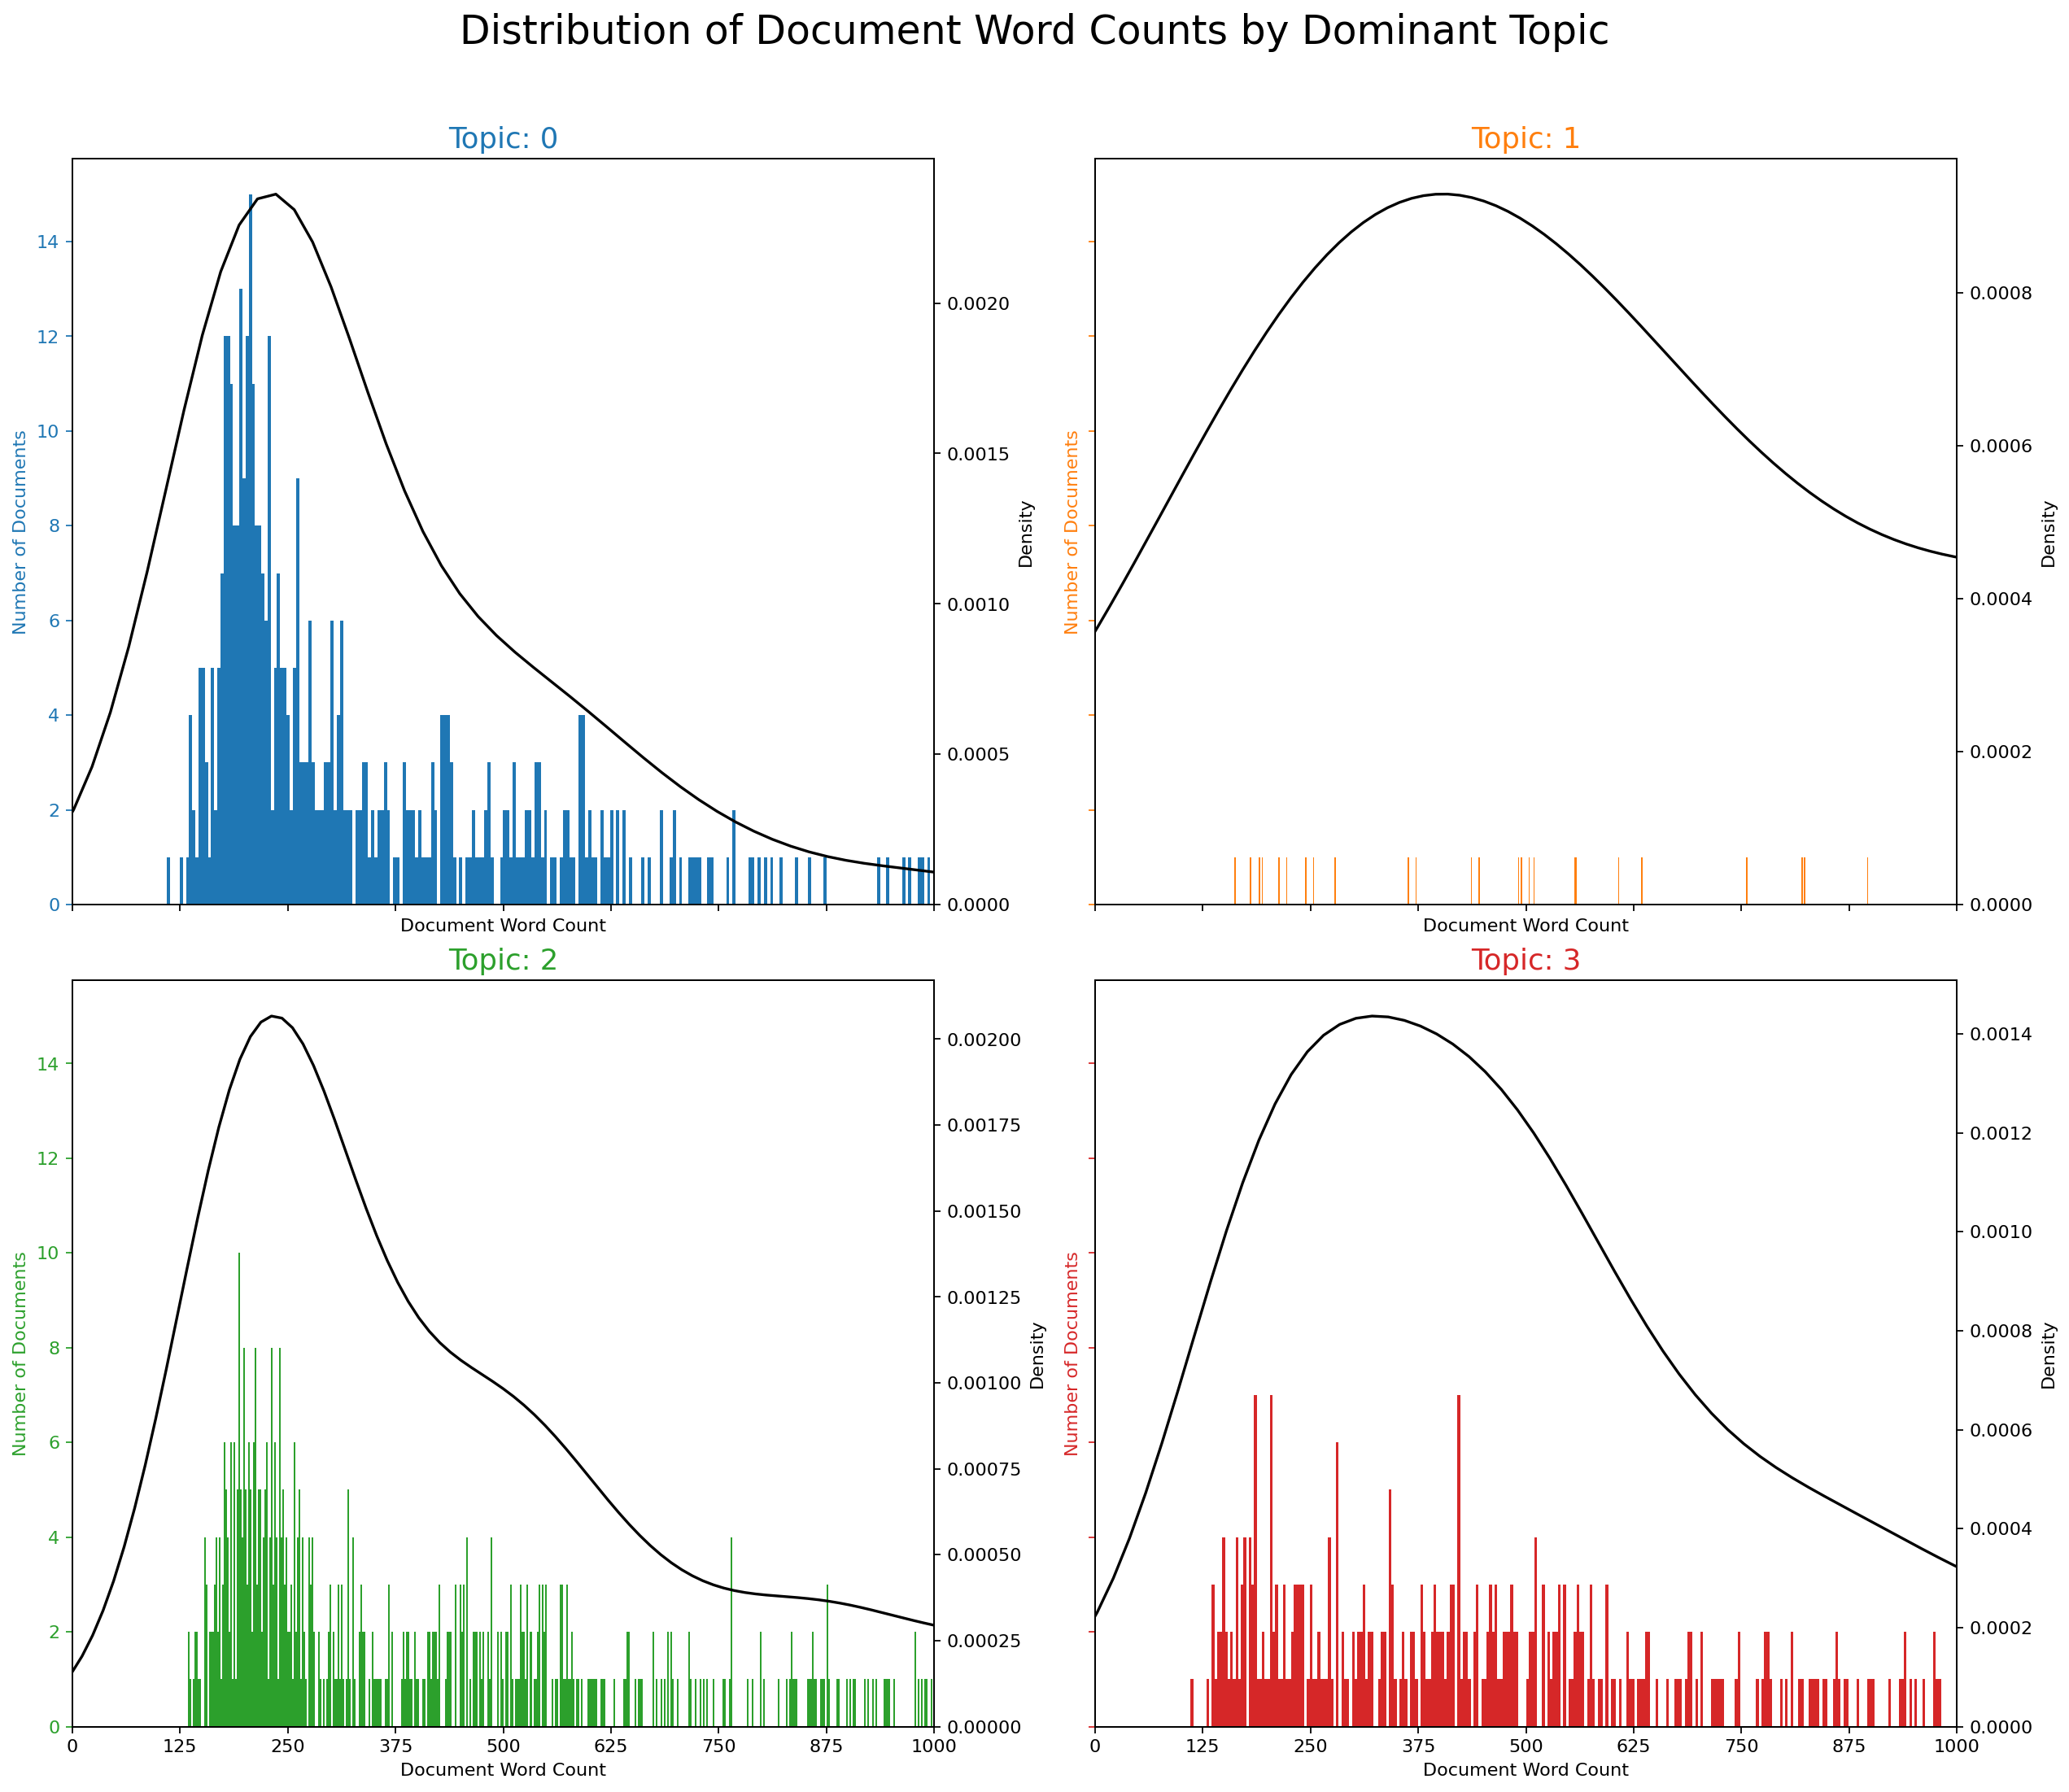

In [46]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

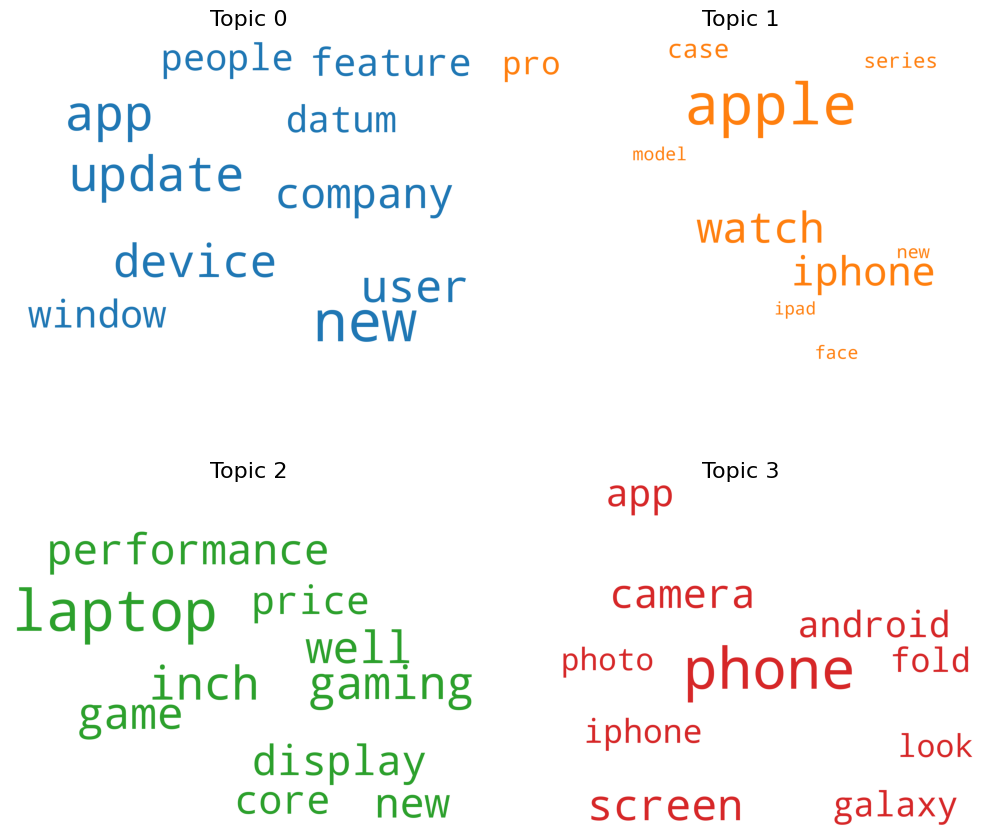

In [47]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<ipython-input-48-3105a4a9aef8>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


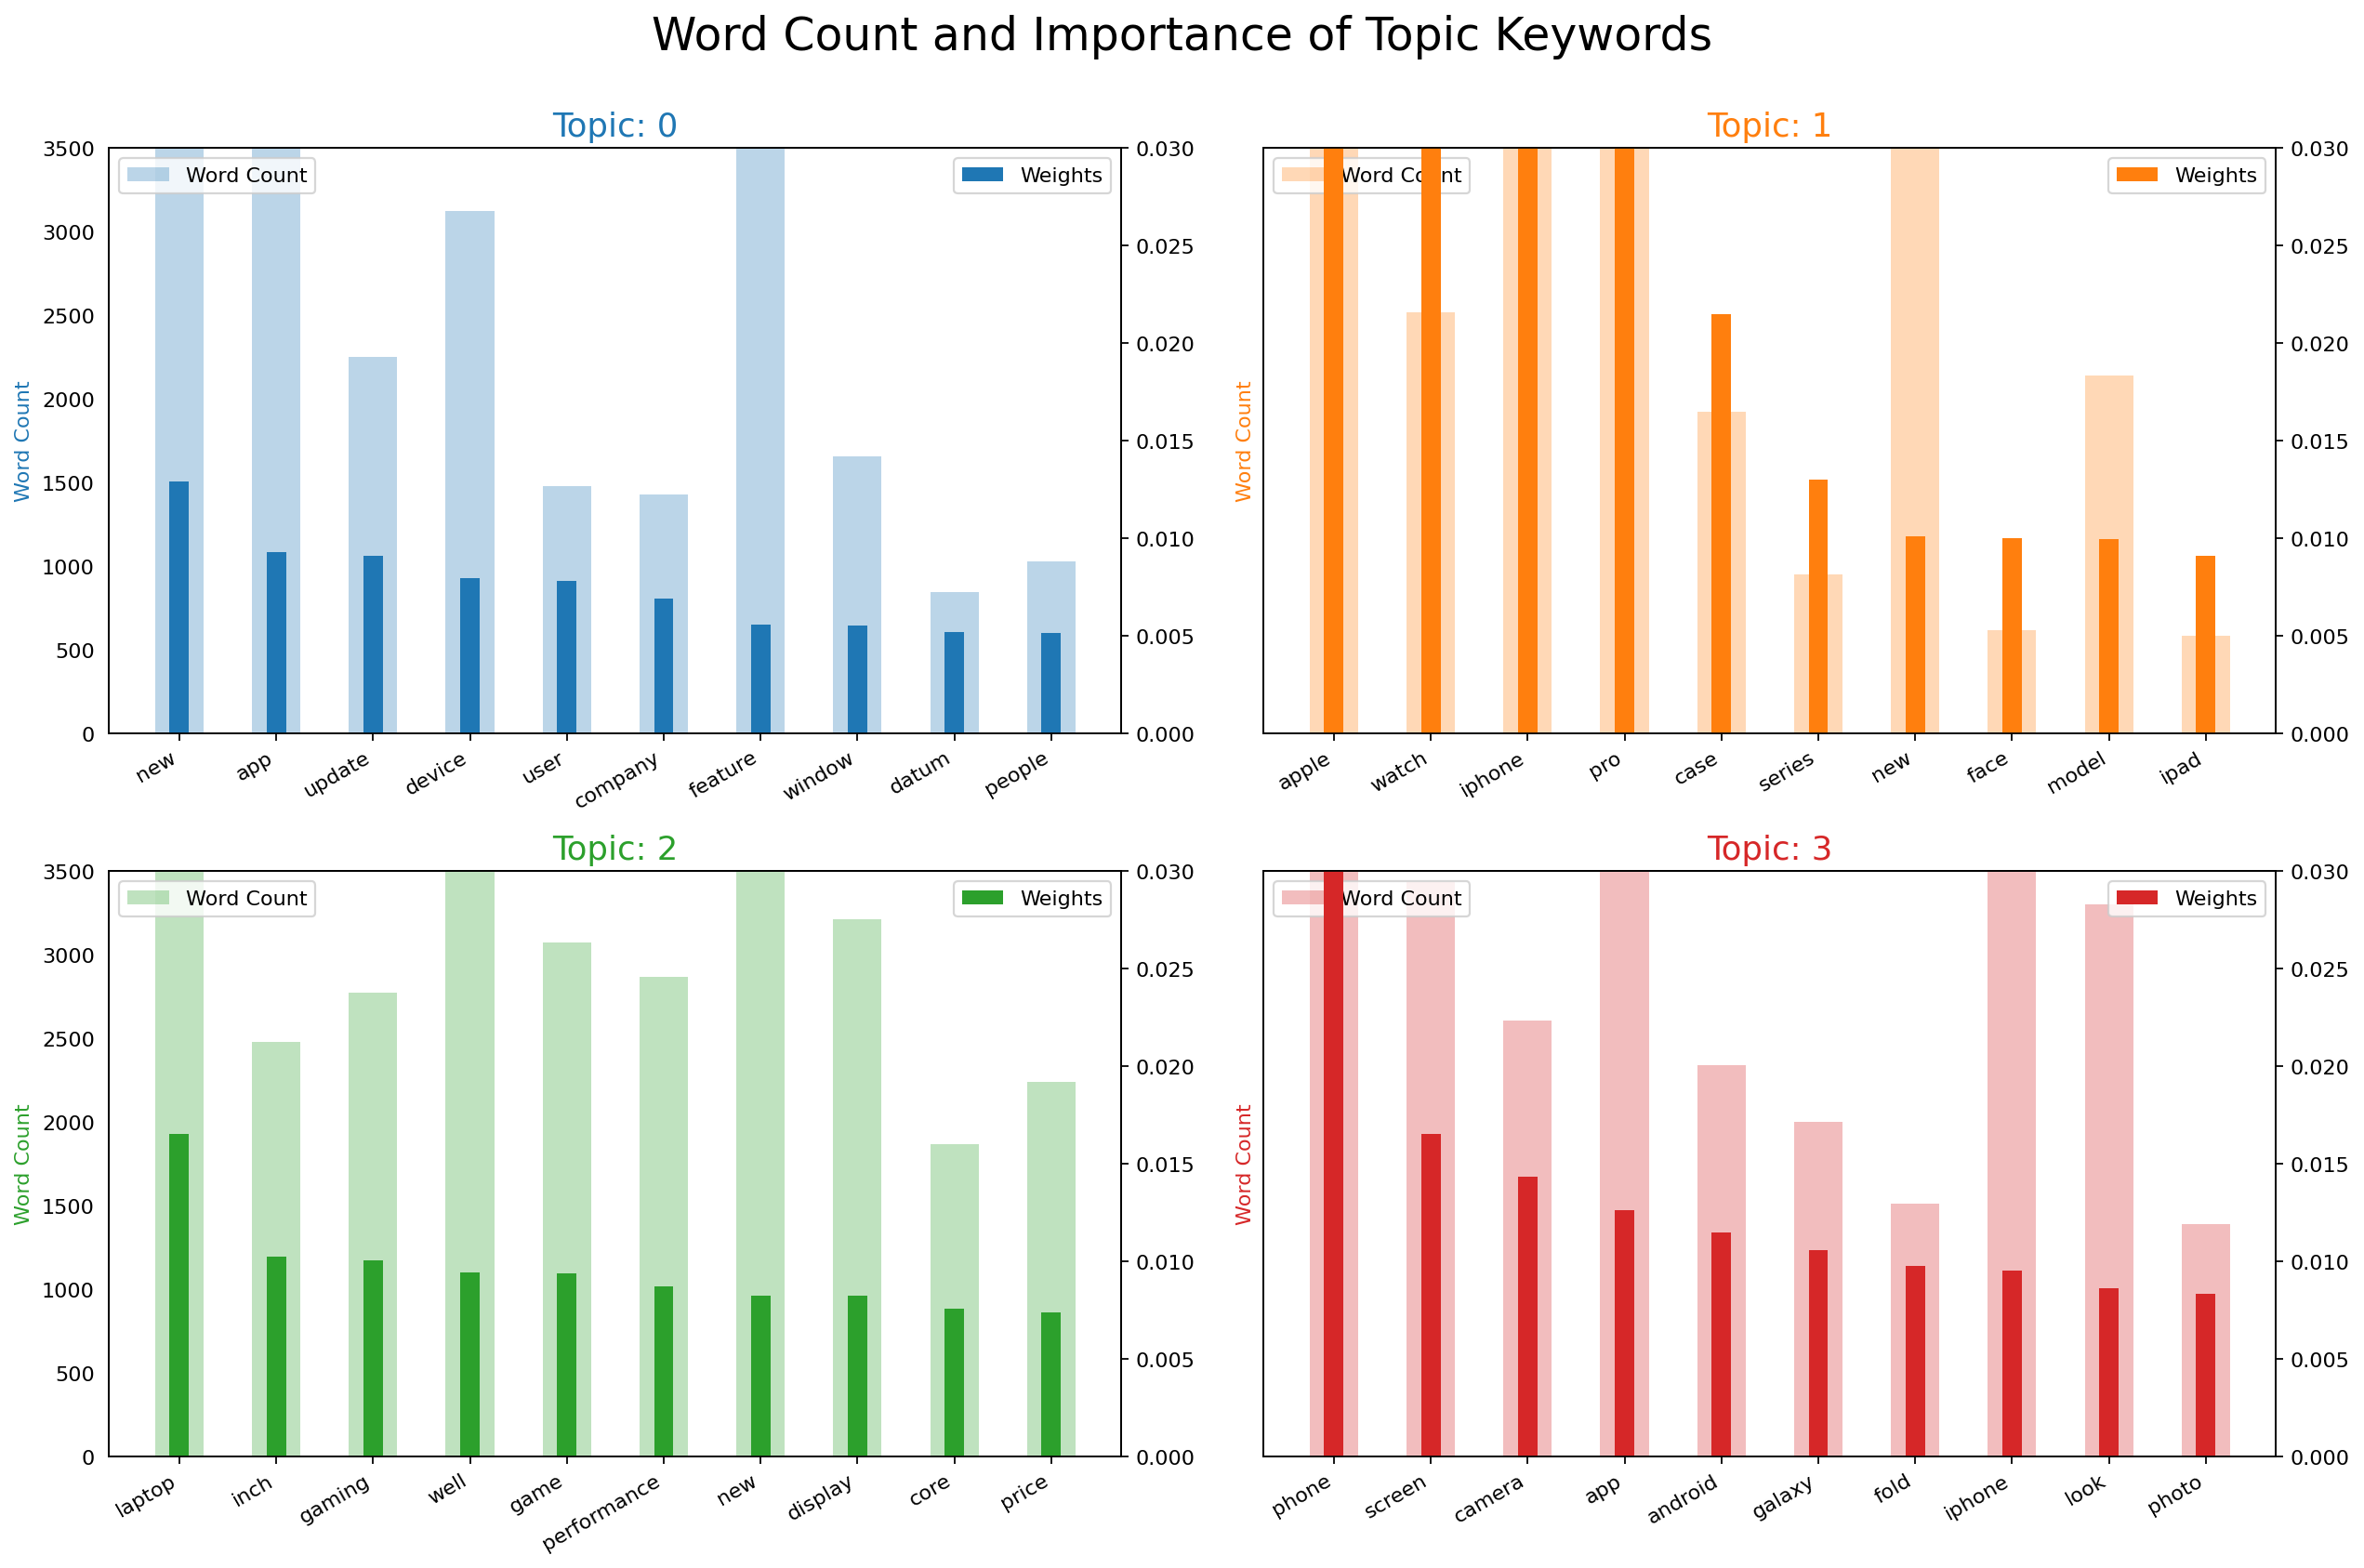

In [48]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=700:stretch=normal:size=16.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.

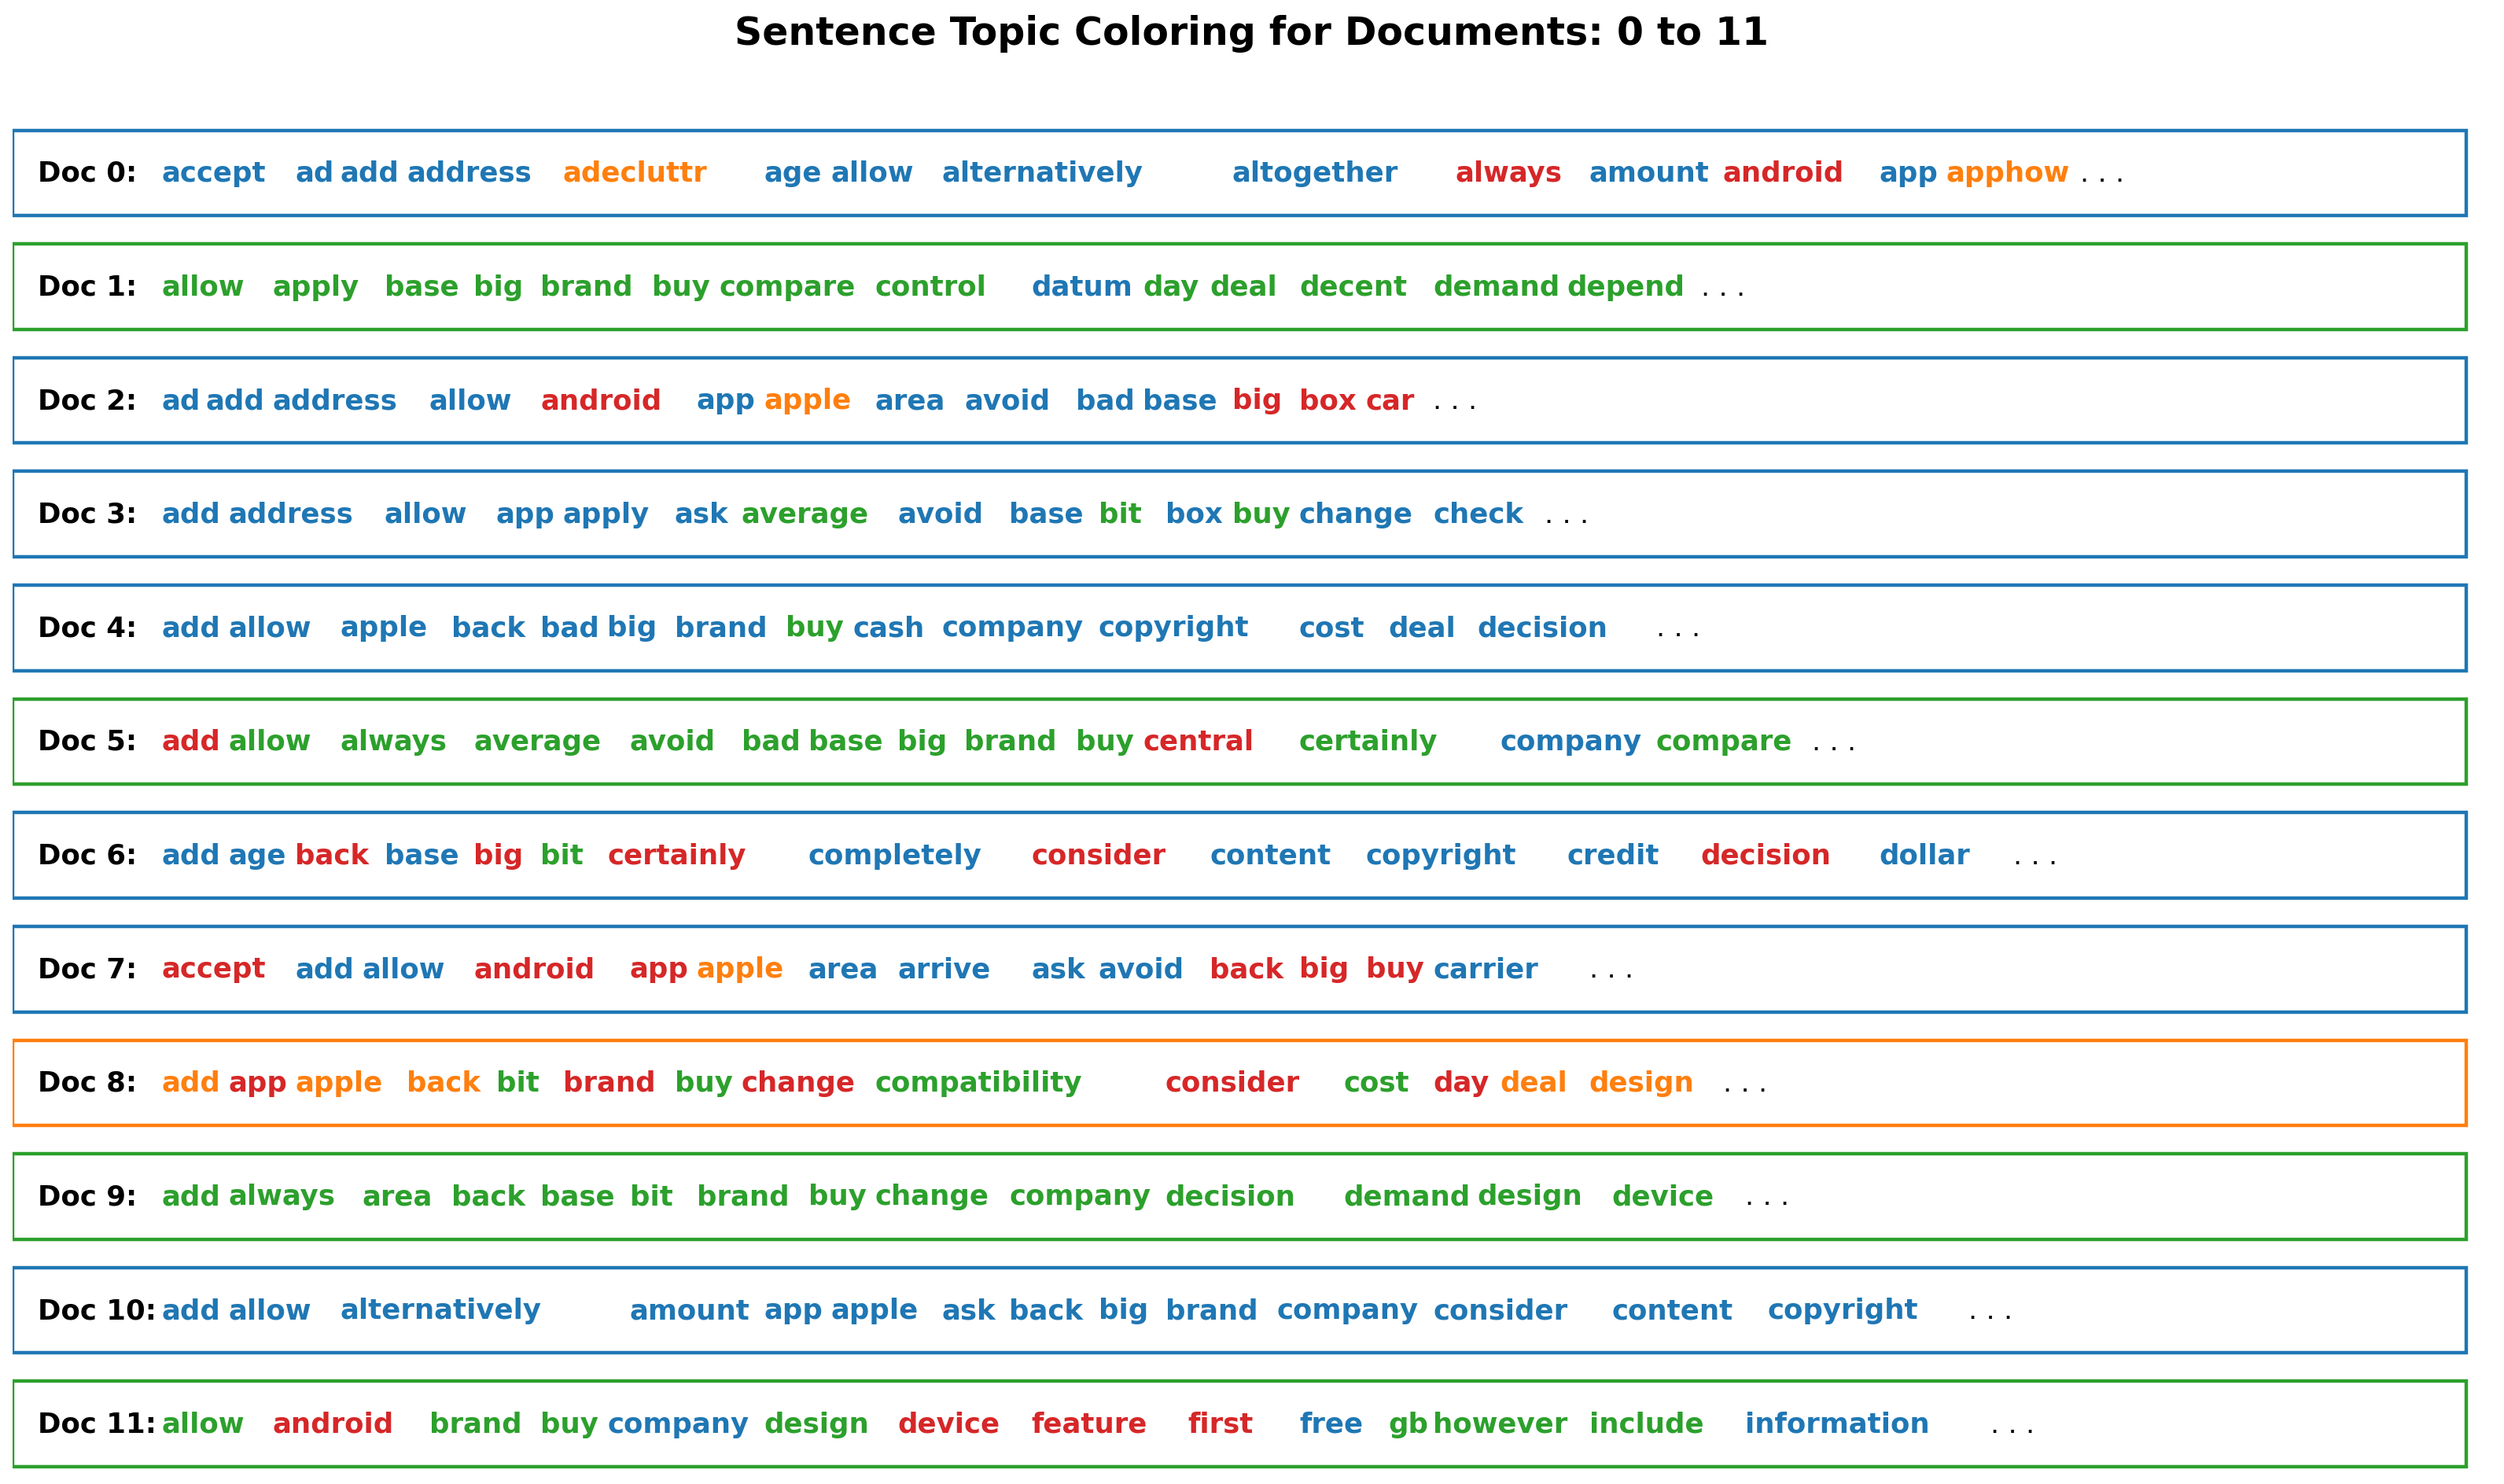

In [49]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [50]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

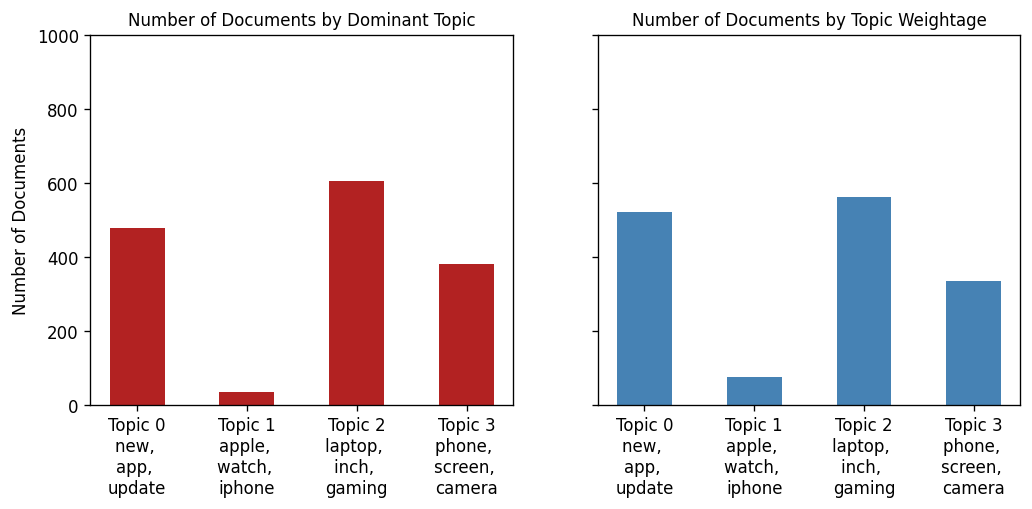

In [51]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [65]:
!zip -r /content/digitalTrends.zip /content/digitalTrends
!zip -r /content/digitalTrendsEntities.zip /content/digitalTrendsEntities
!zip -r /content/whooshIndex.zip /content/whooshIndex
!zip -r /content/whooshIndexEntities.zip /content/whooshIndexEntities

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


updating: content/digitalTrends/ (stored 0%)
updating: content/digitalTrends/c8fc8accf93666aceb71465a3834c2fb.json (deflated 57%)
updating: content/digitalTrends/1288728495f83c6383cf92586d2d9a48.json (deflated 59%)
updating: content/digitalTrends/607f4dbb4486ff415904d53a02abac3a.json (deflated 57%)
updating: content/digitalTrends/29460a404bcc2e580b6b9f6333dbefb1.json (deflated 60%)
updating: content/digitalTrends/8e96d41927fd0465c313eb9add9293eb.json (deflated 54%)
updating: content/digitalTrends/faafea6f177d61fa6ecfe8281ae07c9f.json (deflated 63%)
updating: content/digitalTrends/c9804d3b52d60d5ce5a92d3844ace35c.json (deflated 58%)
updating: content/digitalTrends/c6e7e6a1f63e98f23482a3771960a975.json (deflated 56%)
updating: content/digitalTrends/cff85089406b8bcf3eb5c6e91e22f5df.json (deflated 73%)
updating: content/digitalTrends/56f7b0f1d96fb4449caedb83a19949e0.json (deflated 59%)
updating: content/digitalTrends/56833d25633cd323363e45e3b7aa1d2f.json (deflated 58%)
updating: content/di

mv: cannot move '/content/digitalTrends.zip' to '/content/drive/My Drive/Practica1TGINE/': No such file or directory


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
